In [ ]:
#@title Import dataset from kaggle
! pip install kaggle
! mkdir ~/.kaggle
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download twinkle0705/state-wise-power-consumption-in-india
!unzip state-wise-power-consumption-in-india

In [1]:
pip install prophet

## **Prophet**

In [61]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import pandas as pd
path="/content/drive/MyDrive/energy_dataset.csv"
df_main=pd.read_csv(path)

df= df_main[['utc_timestamp','GB_GBN_solar_generation_actual']].dropna().reset_index(drop=True)
df['utc_timestamp']=df['utc_timestamp'].apply(lambda x: x[:10])
df=df.groupby(['utc_timestamp']).sum().reset_index()
df.columns =['ds','y']
df['ds'] =  pd.to_datetime(df['ds'], format='%Y-%m-%d').dt.date

In [63]:
df.head(10)

,ds,y
0,2015-01-01,756.0
1,2015-01-02,7663.0
2,2015-01-03,2049.0
3,2015-01-04,5423.0
4,2015-01-05,4070.0
5,2015-01-06,5827.0
6,2015-01-07,3546.0
7,2015-01-08,6327.0
8,2015-01-09,5792.0
9,2015-01-10,6958.0


In [ ]:
model = Prophet(daily_seasonality=True) #instantiate Prophet
model.fit(df)

In [ ]:
future_data = model.make_future_dataframe(periods=300, freq = 'D')
forecast_data = model.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

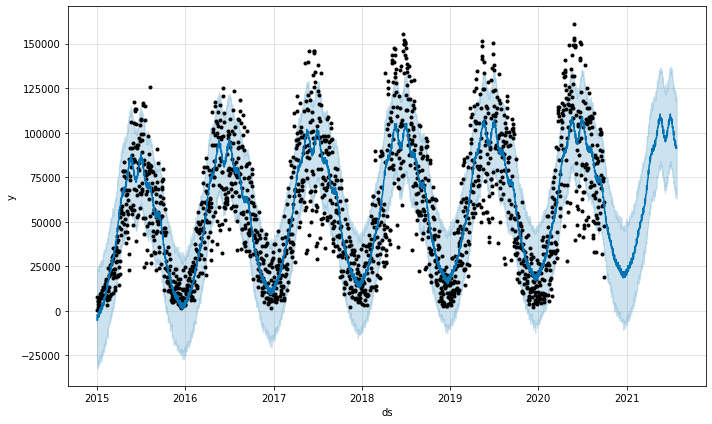

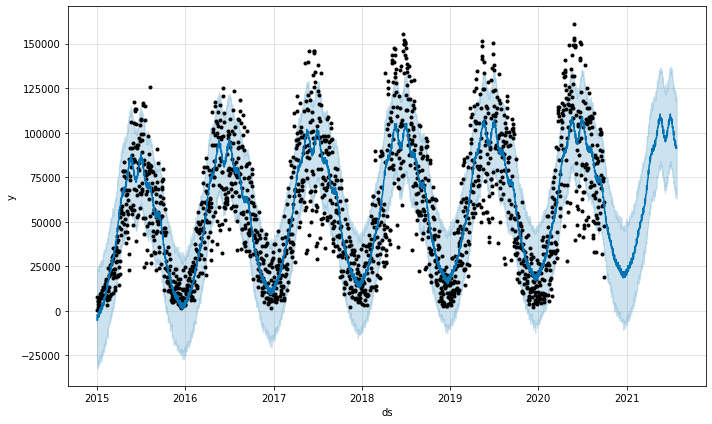

In [ ]:
model.plot(forecast_data)

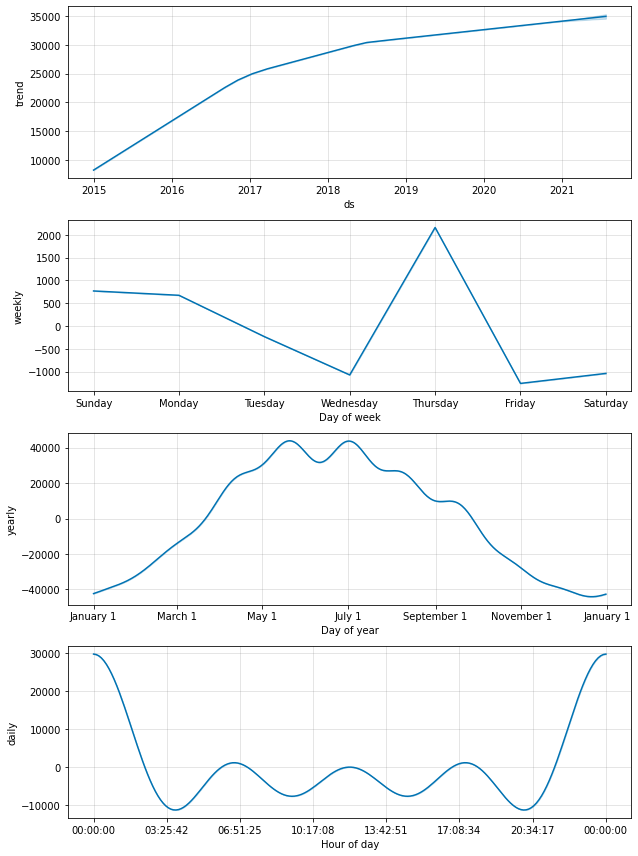

In [ ]:
fig = model.plot_components(forecast_data)

In [ ]:
final_df = pd.DataFrame(forecast_data)
import plotly.graph_objs as go
import plotly.offline as py
#Plot predicted and actual line graph with X=dates, Y=Outbound

actual_chart = go.Scatter(y=df_train["y_orig"], name= 'Actual')
predict_chart = go.Scatter(y=final_df["yhat"], name= 'Predicted')
predict_chart_upper = go.Scatter(y=final_df["yhat_upper"], name= 'Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df["yhat_lower"], name= 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

## **ARIMA**

Reading the data from CSV and plotting the graph

In [64]:
path="/content/drive/MyDrive/energy_dataset.csv"
df_main=pd.read_csv(path)

df= df_main[['utc_timestamp','GB_GBN_solar_generation_actual']].dropna().reset_index(drop=True)
df['utc_timestamp']=df['utc_timestamp'].apply(lambda x: x[:10])
df=df.groupby(['utc_timestamp']).sum().reset_index()
df.columns =['ds','y']
df['ds'] =  pd.to_datetime(df['ds'], format='%Y-%m-%d').dt.date
df.set_index('ds',inplace=True,drop=False)

In [29]:
df.head()

,ds,y
ds,,
2015-01-01,2015-01-01,756.0
2015-01-02,2015-01-02,7663.0
2015-01-03,2015-01-03,2049.0
2015-01-04,2015-01-04,5423.0
2015-01-05,2015-01-05,4070.0


In [30]:
import plotly.graph_objects as px
import plotly.express as go
import numpy as np

y = df['y']
x = df['ds']

plot = px.Figure(data=[px.Scatter(
	x=x,
	y=y,
	mode='lines')
])

plot.update_layout(
	xaxis=dict(
		rangeselector=dict(
			buttons=list([
				dict(count=1,
					step="day",
					stepmode="backward"),
			])
		),
		rangeslider=dict(
			visible=True
		),
	)
)

plot.show()

**Augmented Dicky Fuller** Test to check for stationarity. If the data is not stationary, subtract it by lag of 1 and see if it is stationary. Continue the process till the data is stationary. 

In [31]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
  result=adfuller(series)
  print('ADF Statistics: {}'.format(result[0]))
  print('p- value: {}'.format(result[1]))
  if result[1] <= 0.05:
      print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
  else:
      print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")



In [32]:
adf_test(df['y'])

ADF Statistics: -2.6412217150738644
p- value: 0.08477328915081911
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [65]:
df['y_1']=df['y']-df['y'].shift(1)

In [66]:
adf_test(df['y_1'].dropna())

ADF Statistics: -13.941424688881469
p- value: 4.883863087024334e-26
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


**Train-Test Split**

In [ ]:
df_train=df[:2000]
df_test=df[2000:]
df_test

Drawing **ACF**, **PACF** plots to find the order of MA and AR respectively

In [41]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

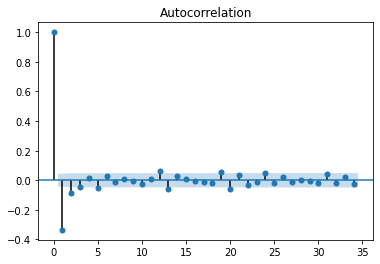

In [45]:
acf = plot_acf(df["y_1"].dropna())

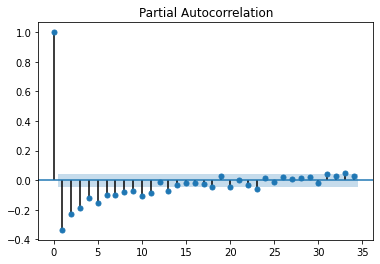

In [46]:
pacf12 = plot_pacf(df["y_1"].dropna())

Using the **ARIMA** model

In [123]:
from statsmodels.tsa.arima.model import ARIMA
model_ARIMA=ARIMA(df_train['y_1'],order=(2,1,11)) # P,D,Q = 2,1,11 from PACF, ACF plots with differencing 1 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [124]:
model_Arima_fit = model_ARIMA.fit()
model_Arima_fit.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    y_1   No. Observations:                 2000
Model:                ARIMA(2, 1, 11)   Log Likelihood              -22593.892
Date:                Fri, 09 Dec 2022   AIC                          45215.784
Time:                        23:08:33   BIC                          45294.190
Sample:                    01-01-2015   HQIC                         45244.574
                         - 06-22-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7544      0.026    -67.543      0.000      -1.805      -1.703
ar.L2         -0.9564      0.026    -37.128      0.000      -1.007      -0.906
ma.L1          0.1989      0.033      5.942      0.000       0.133       0.265
ma.L2         -1.4112      0.031    -45.596      0.000      -1.472      -1.351
ma.L3         -0.7174      0.048    -14.939      0.000      -0.812      -0.623
ma.L4          0.6311      0.044     14.479      0.000       0.546       0.717
ma.L5          0.1612      0.044      3.635      0.000       0.074       0.248
ma.L6          0.0546      0.044      1.238      0.216      -0.032       0.141
ma.L7          0.0773      0.043      1.797      0.072      -0.007       0.162
ma.L8          0.0116      0.042      0.278      0.781      -0.070       0.093
ma.L9         -0.0283      0.038     -0.736      0.462      -0.104       0.047
ma.L10         0.0439      0.022      1.957      0.050   -6.44e-05       0.088
ma.L11        -0.0030      0.022     -0.133      0.894      -0.047       0.041
sigma2      4.246e+08   1.79e-11   2.37e+19      0.000    4.25e+08    4.25e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               154.96
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.3e+35. Standard errors may be unstable.
"""

In [125]:
pred_start_date=df_test.index[0]
pred_end_date=df_test.index[-1]
# print(pred_start_date)
# print(pred_end_date)

In [126]:
pred=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=df_test['y']-pred

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



In [127]:
df['Predicted']=residuals

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6cb54a0b20>,
      dtype=object)

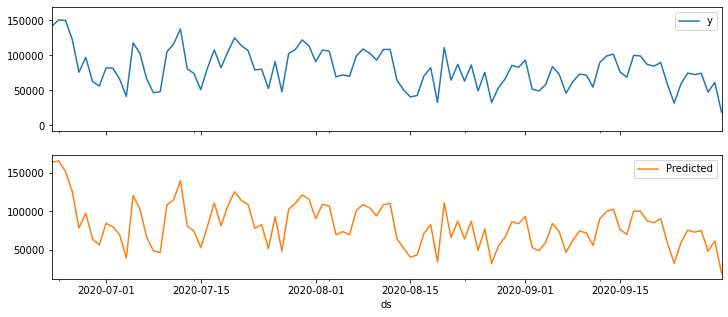

In [128]:
df[['y','Predicted']].plot(figsize=(12,5),xlim=(pd.Timestamp('2020-06-23'), pd.Timestamp('2020-09-30')),subplots=(2,1))

Plotting **MAPE** to as performance metrics

In [129]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    print(mape) 

In [130]:
MAPE(df['y'],df['Predicted'])

1.6150100106158236
